In [1]:
import importlib
import sys

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
import networkx as nx
import torch_geometric as pyg

import LPGNN

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-07 16:39:20.567769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 16:39:20.567797: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [230]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.embedding)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.graph_metrics)
importlib.reload(LPGNN.DataSetup)
importlib.reload(LPGNN.tree_pruning)
importlib.reload(LPGNN.LinkPrediction)

<module 'LPGNN.LinkPrediction' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/LinkPrediction.py'>

# Testing different radius normalizations on LaBNE

In [22]:
def full_test(test_ratio=0.1, chunk_size=10000, step_size=10, EPOCHS = [0, 100, 5000, 10000, 50000, 100000], LaBNE_prior=True):
    PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T, seed, normalize_radius=False)
    print(PS)
    while 1:
        PS = LPGNN.DataSetup.train_test_split(PS, test_ratio=test_ratio, val_ratio=0, neg_samples=False)
        PS_nx = nx.from_edgelist(PS.train_pos_edge_label_index.T.detach().numpy())
        if nx.is_connected(PS_nx):
            print('Train is connected: ', nx.is_connected(PS_nx))
            break
    
    # non normalized radius
    PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=False)
    R_LaBNE_non_norm, P_LaBNE_non_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_nonnorm_{N}_{avg_k}_{gamma}_{T}_{seed}', chunk_size=chunk_size, skip_file_prep=False, step_size=step_size)
    print(" | len: ", R_LaBNE_non_norm.__len__(), P_LaBNE_non_norm.__len__())
    max_non_norm_radius = PS_LaBNE.LaBNE_node_polar_positions[:,0].max()

    # normalized radius
    radius = [0.1, 0.2, 0.5, 0.7, 0.8, 0.9, 1, 2, 5, 10, 20, 50, 100, 500, 10000]
    R_LaBNE_norm = []
    P_LaBNE_norm = []
    for r in radius:
        PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=r)
        R, P = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_norm_{N}_{avg_k}_{gamma}_{T}_{seed}_{r}', chunk_size=chunk_size, skip_file_prep=False, step_size=step_size)
        R_LaBNE_norm.append(R)
        P_LaBNE_norm.append(P)
        print(" | len: ", R.__len__(), P.__len__())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(f'PS: N={N}, avg_k={avg_k}, gamma={gamma}, T={T}, seed={seed}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(alpha=0.5)

    colors = plt.cm.viridis(np.linspace(0, 1, len(radius)))
    for i, r in enumerate(radius):
        ax.plot(R_LaBNE_norm[i], P_LaBNE_norm[i], label=f'Norm ({r})', c=colors[i])
    ax.plot(R_LaBNE_non_norm, P_LaBNE_non_norm, label=f'LaBNE non norm ({max_non_norm_radius:.2f})', c='r', linestyle='--')

    ax.legend()

    return fig, ax

Data(is_directed=False, is_PS=True, num_nodes=1200, avg_k=8, gamma=2.4, T=0.2, seed=55, node_polar_positions=[1200, 2], edge_index=[2, 9580], node_positions=[1200, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(1916.)  . Total test edges:  1916
Generating hyperbolic distances and saving to file  data/Distance_Lists/Floating_point_precision/PS_LaBNE_nonnorm_1200_8_2.4_0.2_55
Sorting file...
Reading file and generating precision-recall curve...
index: 718500, R: 1.000, P: 0.003 | len:  1438 1438
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(1916.)  . Total test edges:  1916
Generating hyperbolic distances and saving to file  data/Distance_Lists/Floating_point_precision/PS_LaBNE_norm_1200_8_2.4_0.2_55_0.1
Sorting file...
Reading file and generating precision-recall curve...
index: 718000, R: 1.000, P: 0.003 | len:  1437 1437
Calculating best minimal value fo

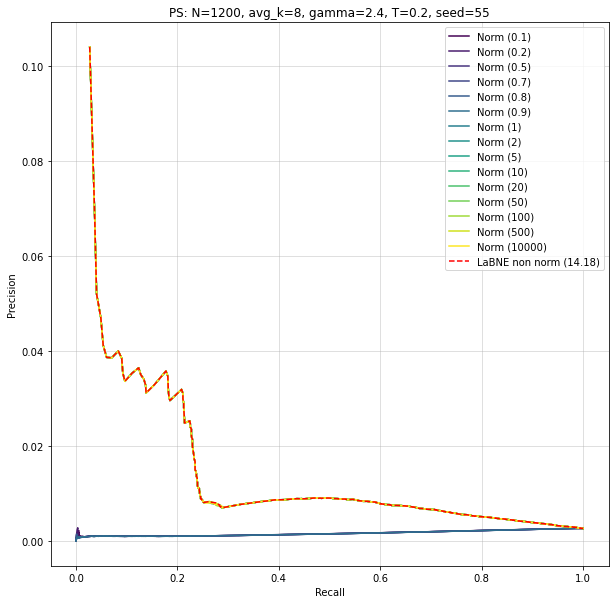

In [24]:
N = 1200
avg_k = 8
gamma = 2.4
T = 0.2
seed = 55
fig, ax = full_test(test_ratio=0.4, chunk_size=10000, step_size=500, EPOCHS=[1000], LaBNE_prior=True)

# The main result is that w/ radius > 1, there seems to be a convergence to good precision.

# Now on Poincaŕe Embedding

In [52]:
def full_test(test_ratio=0.1, chunk_size=10000, step_size=10, EPOCHS = [0, 100, 5000, 10000, 50000, 100000], LaBNE_prior=True, skip_file_prep=False, radius = [0.1, 0.2, 0.5, 0.7, 0.8, 0.9, 1, 2, 5, 10, 20, 50, 100, 500, 10000]
    ):
    PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T, seed, normalize_radius=False)
    print(PS)
    while 1:
        PS = LPGNN.DataSetup.train_test_split(PS, test_ratio=test_ratio, val_ratio=0, neg_samples=False)
        PS_nx = nx.from_edgelist(PS.train_pos_edge_label_index.T.detach().numpy())
        if nx.is_connected(PS_nx):
            print('Train is connected: ', nx.is_connected(PS_nx))
            break
    
    # non normalized radius
    PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=False)
    R_LaBNE_non_norm, P_LaBNE_non_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_nonnorm_{N}_{avg_k}_{gamma}_{T}_{seed}', chunk_size=chunk_size, skip_file_prep=skip_file_prep, step_size=step_size)
    print(" | len: ", R_LaBNE_non_norm.__len__(), P_LaBNE_non_norm.__len__())

    # normalized radius
    PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=.1)
    R_LaBNE_norm, P_LaBNE_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_norm_{N}_{avg_k}_{gamma}_{T}_{seed}', chunk_size=chunk_size, skip_file_prep=skip_file_prep, step_size=step_size)
    print(" | len: ", R_LaBNE_norm.__len__(), P_LaBNE_norm.__len__())

    R_Poincare = []
    P_Poincare = []
    for r_p in radius:
        for epochs in EPOCHS:
            PS_Poincare = PS_LaBNE.clone()
            #r, theta = PS_Poincare.LaBNE_node_polar_positions[:, 0], PS_Poincare.LaBNE_node_polar_positions[:, 1]
            #r = r / r.max() * 0.5
            #PS_Poincare.LaBNE_node_polar_positions[:,0] = r
            #x, y = r * th.cos(theta), r * th.sin(theta)
            #PS_Poincare.LaBNE_node_positions = th.stack([x, y], dim=1)
            if LaBNE_prior: init_pos = PS_Poincare.LaBNE_node_positions
            else: init_pos = None
            PS_Poincare = LPGNN.poincare_embedding.poincare_embedding(PS_Poincare, edge_index='train_pos_edge_label_index', epochs=epochs, lr=0.03, init_pos=init_pos)
            # rescale radius
            r = PS_Poincare.PoincareEmbedding_node_polar_positions[:, 0]
            r = r / r.max() * r_p
            PS_Poincare.PoincareEmbedding_node_polar_positions[:,0] = r
            R, P = LPGNN.LinkPrediction.precision_recall_score_file(PS_Poincare, position_name='PoincareEmbedding_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_Poincare_rescale_{N}_{avg_k}_{gamma}_{T}_{seed}_{epochs}', chunk_size=chunk_size, skip_file_prep=skip_file_prep, step_size=step_size)
            R_Poincare.append(R)
            P_Poincare.append(P)
            print(" | len: ", R.__len__(), P.__len__())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(f'PS: N={N}, avg_k={avg_k}, gamma={gamma}, T={T}, seed={seed}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid(alpha=0.5)

    colors = plt.cm.viridis(np.linspace(0, 1, len(radius)))
    for i, r_p in enumerate(radius):
        ax.plot(R_Poincare[i], P_Poincare[i], label=f'PE ({r_p})', c=colors[i])
    ax.plot(R_LaBNE_non_norm, P_LaBNE_non_norm, label='LaBNE non norm', c='r', linestyle='--')
    ax.plot(R_LaBNE_norm, P_LaBNE_norm, label='LaBNE norm', c='g', linestyle='--')

    ax.legend()

    return fig, ax

Data(is_directed=False, is_PS=True, num_nodes=1500, avg_k=6, gamma=2.4, T=0.2, seed=55, node_polar_positions=[1500, 2], edge_index=[2, 8988], node_positions=[1500, 2])
Train is connected:  True
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(1797.)  . Total test edges:  1797
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_nonnorm_1500_6_2.4_0.2_55
Sorting file...
Reading file and generating precision-recall curve...
index: 1123000, R: 1.000, P: 0.002 | len:  2247 2247
Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(1797.)  . Total test edges:  1797
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_LaBNE_norm_1500_6_2.4_0.2_55
Sorting file...
Reading file and generating precision-recall curve...
index: 1123000, R: 1.000, P: 0.002 | len:  2247 2247


100%|██████████| 50000/50000 [01:05<00:00, 764.50it/s]


Generating test mask...
Total test mask:  tensor(1797.)  . Total test edges:  1797
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1500_6_2.4_0.2_55_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 1123500, R: 1.000, P: 0.002 | len:  2248 2248


100%|██████████| 50000/50000 [00:57<00:00, 864.14it/s] 


Generating test mask...
Total test mask:  tensor(1797.)  . Total test edges:  1797
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1500_6_2.4_0.2_55_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 1123500, R: 1.000, P: 0.002 | len:  2248 2248


100%|██████████| 50000/50000 [00:58<00:00, 858.74it/s] 


Generating test mask...
Total test mask:  tensor(1797.)  . Total test edges:  1797
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1500_6_2.4_0.2_55_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 1123500, R: 1.000, P: 0.002 | len:  2248 2248


100%|██████████| 50000/50000 [00:56<00:00, 886.32it/s] 


Generating test mask...
Total test mask:  tensor(1797.)  . Total test edges:  1797
Generating hyperbolic distances and saving to file  data/Distance_Lists/PS_epoch_testing/PS_Poincare_rescale_1500_6_2.4_0.2_55_50000
Sorting file...
Reading file and generating precision-recall curve...
index: 1123500, R: 1.000, P: 0.002 | len:  2248 2248


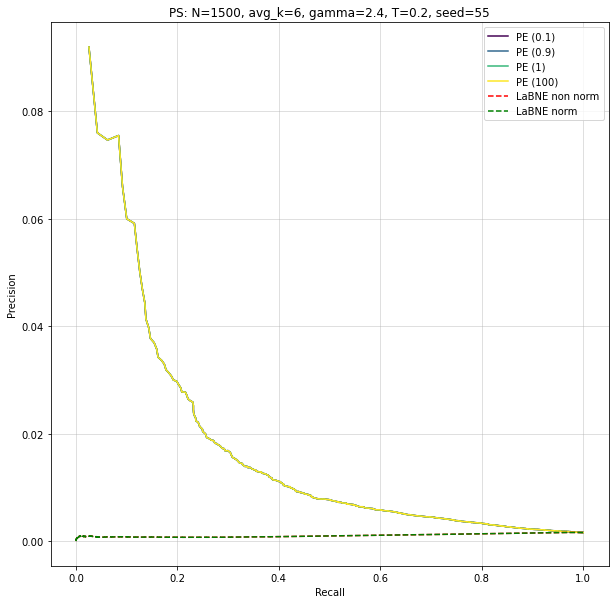

In [53]:
N = 1500
avg_k = 6
gamma = 2.4
T = 0.2
seed = 55
fig, ax = full_test(test_ratio=0.4, chunk_size=10000, step_size=500, EPOCHS=[50000], LaBNE_prior=True, skip_file_prep=False, radius=[0.1, 0.9, 1, 100])

In [14]:
def dist(u, v, r=1):
    """ Compute the Poincare distance between two vectors. """
    sqdist = th.sum((u - v) ** 2, dim=-1)/r
    squnorm = th.sum(u ** 2, dim=-1)/r
    sqvnorm = th.sum(v ** 2, dim=-1)/r
    x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + 1e-5
    z = th.sqrt(x ** 2 - 1)
    return th.log(x + z)

In [3]:
def hyperbolic_distances(u:th.Tensor, v:th.Tensor):
    # convert u to polar coordinates
    r_u = th.norm(u)
    theta_u = th.atan2(u[1], u[0])
    # convert v to polar coordinates
    r_v = th.norm(v)
    theta_v = th.atan2(v[1], v[0])

    angular_distance = th.min(2*th.pi-th.abs(theta_v-theta_u), th.abs(theta_v-theta_u))
    d = th.arccosh(th.cosh(r_v)*th.cosh(r_u) - th.sinh(r_v)*th.sinh(r_u)*th.cos(angular_distance))
    return d

In [77]:
u = th.tensor([0.3, 0.5, 0.1], dtype=th.float)
v = th.tensor([0.5, 0.2, 0.2], dtype=th.float)

In [78]:
dist(u, v, th.inf)

tensor(0.0045)

In [79]:
hyperbolic_distances(u,v)

tensor(0.3915)

In [80]:
u[1:]

tensor([0.5000, 0.1000])

In [81]:
th.norm(u), th.sqrt(u[0]**2 + u[1]**2 + u[2]**2)

(tensor(0.5916), tensor(0.5916))

In [141]:
def to_spherical(u:th.Tensor):
    """ Assumes a N-dimensional vector in cartesian coordinates (x_1, x_2, ..., x_n).
    Returns a N-dimensional vector in spherical coordinates (r, theta_1, theta_2, ..., theta_n-1). """

    u_s = th.zeros_like(u)
    u_s[0] = th.norm(u) # r
    for i in range(1, u_s.shape[0]-1):
        # set hyperspherical coordinates
        u_s[i] = th.acos(u[i-1] / th.norm(u[i-1:]))
    # set polar coordinate
    u_s[-1] = th.arccos(u[-2] / th.sqrt(u[-1]**2 + u[-2]**2))
    if u[-1] < 0: u_s[-1] = 2*th.pi - u_s[-1]
    u_s = th.nan_to_num_(u_s, nan=0)
    return u_s

def to_cartesian(u:th.Tensor):
    """ Assumes a N-dimensional vector in spherical coordinates (r, theta_1, theta_2, ..., theta_n-1).
    Returns a N-dimensional vector in cartesian coordinates (x_1, x_2, ..., x_n). """

    u_c = th.zeros_like(u)
    for i in range(u_c.shape[0]-1):
        # set cartesian coordinates
        u_c[i] = u[0] * th.prod(th.sin(u[1:i+1])) * th.cos(u[i+1])
    u_c[-1] = u[0] * th.prod(th.sin(u[1:]))
    return u_c

In [295]:
u = th.Tensor([[10, 0.1, 0.1],
               [-5, -0.1, 0.1],])

In [296]:
u_s = LPGNN.distances.to_spherical(u)
u_s

tensor([[10.0010,  0.0141,  0.7854],
        [ 5.0020,  3.1133,  2.3562]])

In [297]:
u_c = LPGNN.distances.to_cartesian(u_s)
u_c

tensor([[10.0000,  0.1000,  0.1000],
        [-5.0000, -0.1000,  0.1000]])

In [250]:
u_c

tensor([[1.0000e+01, 0.0000e+00, 8.1124e-02],
        [2.0000e-01, 0.0000e+00, 5.0003e-03]])

In [163]:
B = th.Tensor([1,2,3,4,5,6])
A = th.zeros_like(B)

In [165]:
B[1:]

tensor([2., 3., 4., 5., 6.])

In [19]:
PS = LPGNN.popularity_similarity.generatePSNetwork(N=2000, avg_k=8, gamma=2.6, T=0.1, seed=100, normalize_radius=False)

In [24]:
PS_LaBNE = LPGNN.labne.generateLaBNE(PS, dim=3, normalize_radius=0.5)

Calculating best minimal value for power law fit


/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/labne.py:59: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811740025/work/aten/src/ATen/native/Copy.cpp:244.)
  x_LE_cartesian = th.Tensor(eigenvectors[:,1:])


In [25]:
PS_LaBNE

Data(is_directed=False, is_PS=True, num_nodes=200, avg_k=2, gamma=2.6, T=0.0, seed=100, dim=3, node_polar_positions=[200, 3], edge_index=[2, 398], node_positions=[200, 3], LaplacianEigenmaps_node_positions=[200, 3], LaBNE_node_polar_positions=[200, 3], LaBNE_node_positions=[200, 3])

In [26]:
x_cart = PS_LaBNE.LaBNE_node_positions.detach().numpy()

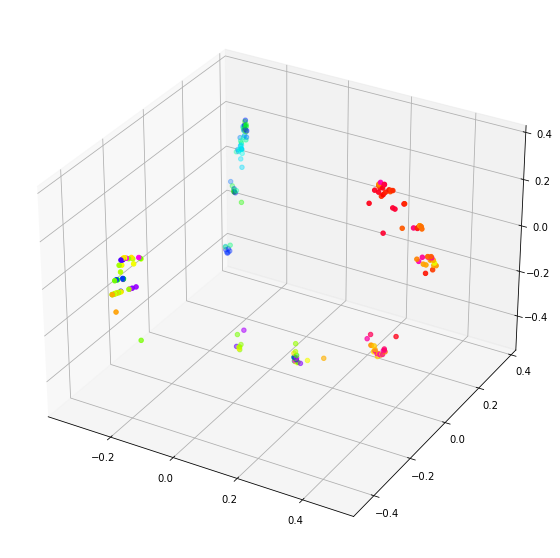

In [27]:
# plot x_cart as 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# plot x_cart as 3D scatter plot, use PS.node_polar_positions[:,1] as color, using a rainbbow colormap
ax.scatter(x_cart[:,0], x_cart[:,1], x_cart[:,2], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')

In [35]:
N = 200
dim = 5

t = th.zeros(size=(N, dim))
# Set node angular positions to random uniform distribution [0, 2π). We
# can do this now because it doesn't affect PS algorithm.
t[:,1:] = th.rand(size=(N, dim-1))*2*th.pi

In [39]:
u = th.random.normal(0, 1, size=(N, dim))
LPGNN.distances.poincare_dist(u[0], u[1:])

tensor([0.6059, 0.6059])

In [45]:
u = th.randint(0, 100, size=(N, dim))/100

In [47]:
LPGNN.distances.poincare_dist(u[:10], u[11])

tensor([3.7326, 3.8680, 3.9548, 5.1845, 3.6159, 4.3311,    nan, 3.6386, 6.7747,
           nan])

In [48]:
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.popularity_similarity)

<module 'LPGNN.popularity_similarity' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/popularity_similarity.py'>

In [49]:
PS = LPGNN.popularity_similarity.generatePSNetwork(N=1000, avg_k=8, gamma=2.6, T=0.00, seed=100, dim=2, normalize_radius=False)

6.727305347225017
6.921652547548353
7.0998106019263245
7.263513430464101
7.414578747869209
7.554639267332331
7.685093260774908
7.8071199571410315
7.921711004534448
8.029702406043818
8.131802407751062
8.228614566205021
8.320656422661084
8.408374508829946
8.492156397074655
8.572340404625734
8.649223444839999
8.723067414606113
8.794104421818103
8.862541089571335
8.928562121521047
8.992333272601716
9.054003838344697
9.11370875217651
9.171570361640804
9.22769994017112
9.28219897987224
9.335160302006658
9.386669014973236
9.436803344085611
9.485635353089101
9.533231573852616
9.579653557850119
9.624958360760601
9.669198969655415
9.71242468072071
9.754681434213113
9.796012112315832
9.836456804707929
9.876053045948773
9.914836028185846
9.952838792196328
9.990092399353827
10.026626086757958
10.062467407464545
10.097642357499474
10.132175491121819
10.166090025615981
10.19940793673311
10.232150045764811
10.26433609911385
10.295984841124143
10.327114080843582
10.357740753316047
10.387880975931733
10

In [46]:
2 * np.log(999)

13.813509557297108

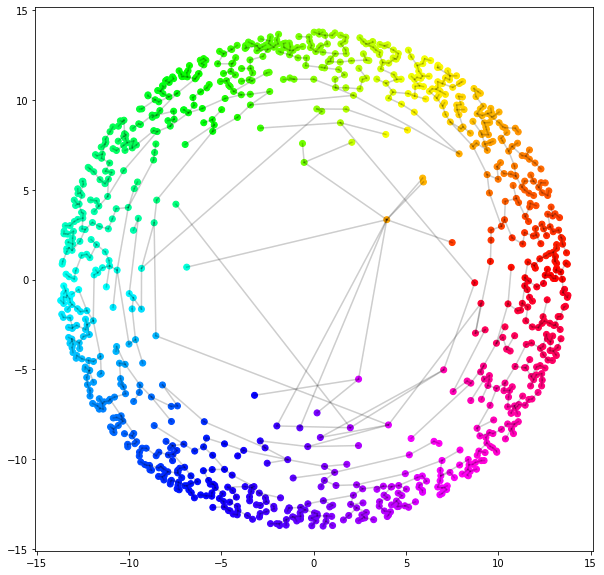

In [36]:
x_cart = PS.node_positions.detach().numpy()
# plot x_cart as 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for edge in PS.edge_index.T:
    ax.plot(x_cart[edge,0], x_cart[edge,1], c='k', alpha=0.1)
# plot x_cart as 3D scatter plot, use PS.node_polar_positions[:,1] as color, using a rainbbow colormap
ax.scatter(x_cart[:,0], x_cart[:,1], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')

(<Figure size 720x720 with 1 Axes>, <PolarAxesSubplot:>)

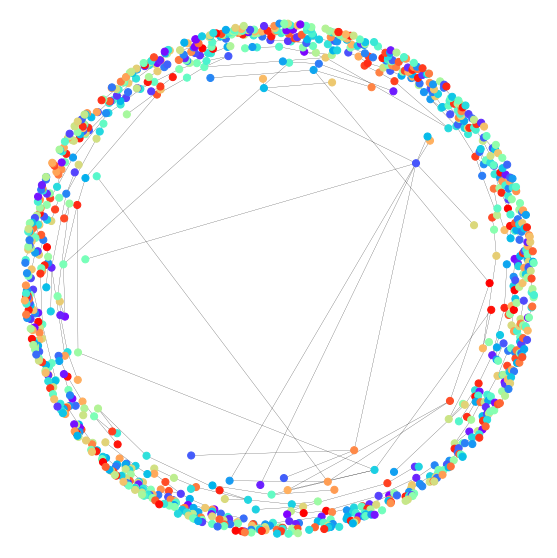

In [41]:
LPGNN.popularity_similarity.drawPSNetwork(PS, polar_projection=True)

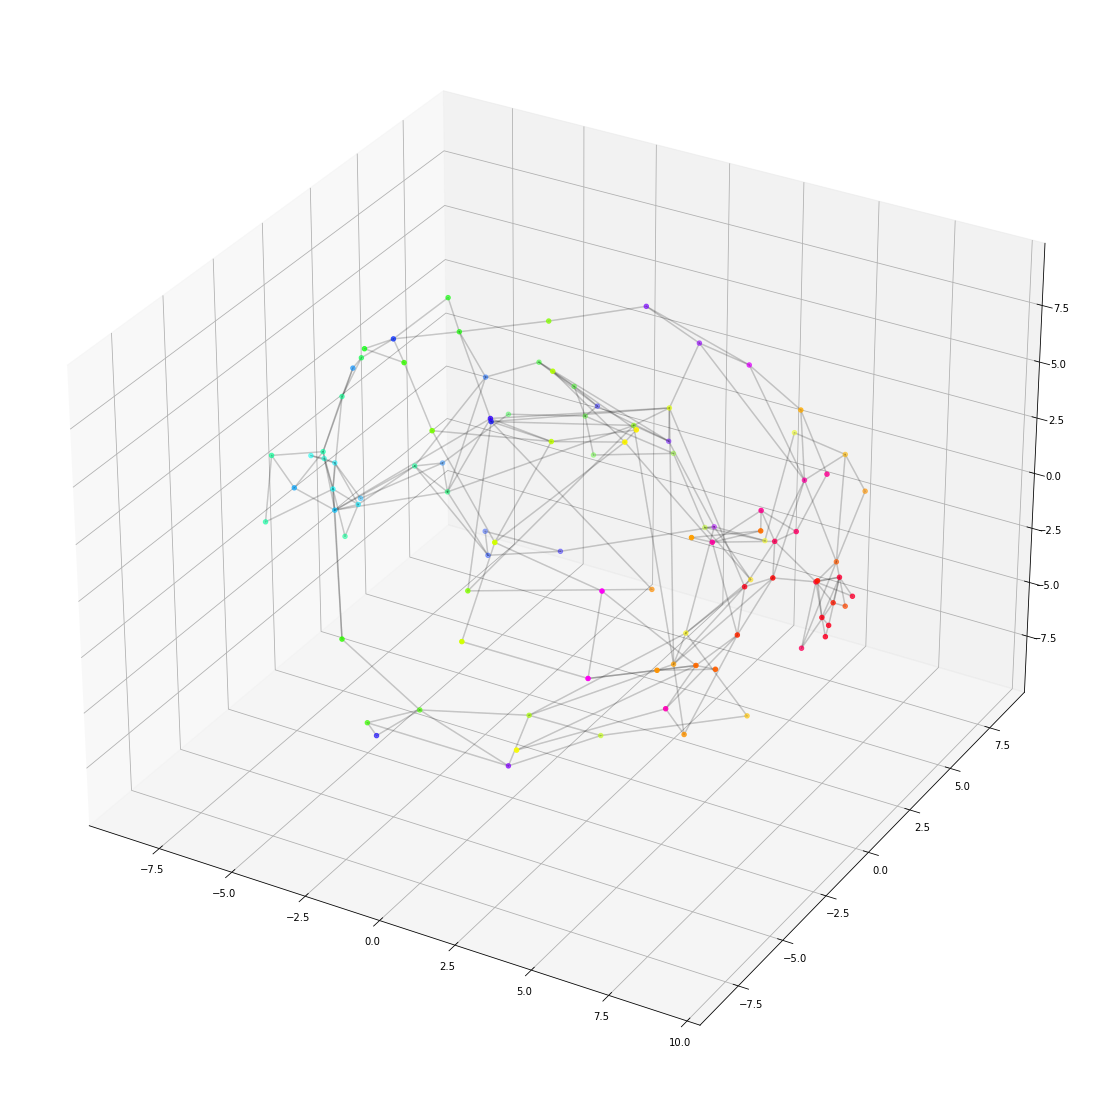

In [154]:
x_cart = PS.node_positions.detach().numpy()
# plot x_cart as 3D scatter plot
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
# plot x_cart as 3D scatter plot, use PS.node_polar_positions[:,1] as color, using a rainbbow colormap
ax.scatter(x_cart[:,0], x_cart[:,1], x_cart[:,2], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')

for edge in PS.edge_index.T:
    ax.plot(x_cart[edge,0], x_cart[edge,1], x_cart[edge,2], c='k', alpha=0.1)

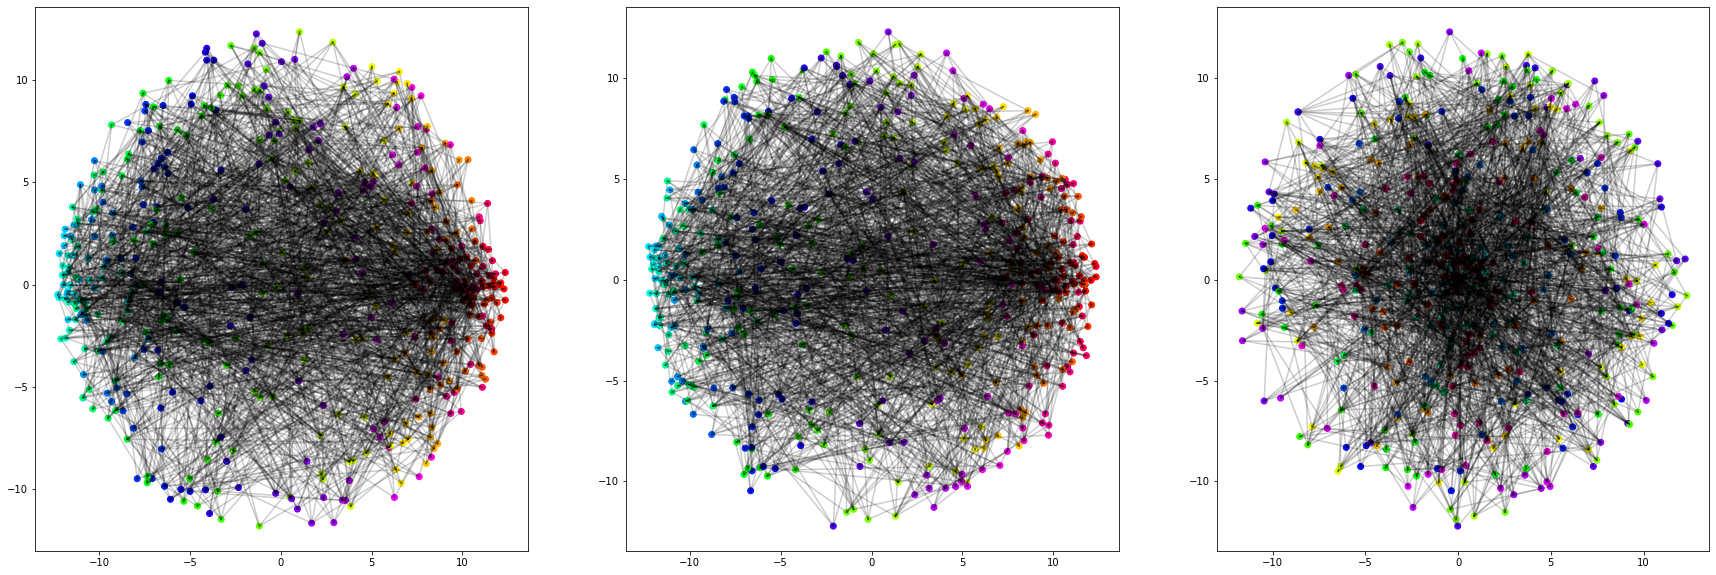

In [39]:
x_cart = PS.node_positions.detach().numpy()
# plot x_cart as 3D scatter plot
fig, ax = plt.subplots(1, 3, figsize=(30,10))
ax[0].scatter(x_cart[:,0], x_cart[:,1], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')
for edge in PS.edge_index.T:
    ax[0].plot(x_cart[edge,0], x_cart[edge,1], c='k', alpha=0.1)
ax[1].scatter(x_cart[:,0], x_cart[:,2], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')
for edge in PS.edge_index.T:
    ax[1].plot(x_cart[edge,0], x_cart[edge,2], c='k', alpha=0.1)
ax[2].scatter(x_cart[:,1], x_cart[:,2], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')
for edge in PS.edge_index.T:
    ax[2].plot(x_cart[edge,1], x_cart[edge,2], c='k', alpha=0.1)

In [53]:
PS_LaBNE = LPGNN.labne.generateLaBNE(PS, dim=5)

Calculating best minimal value for power law fit


In [54]:
x_cart = PS_LaBNE.LaBNE_node_positions.detach().numpy()

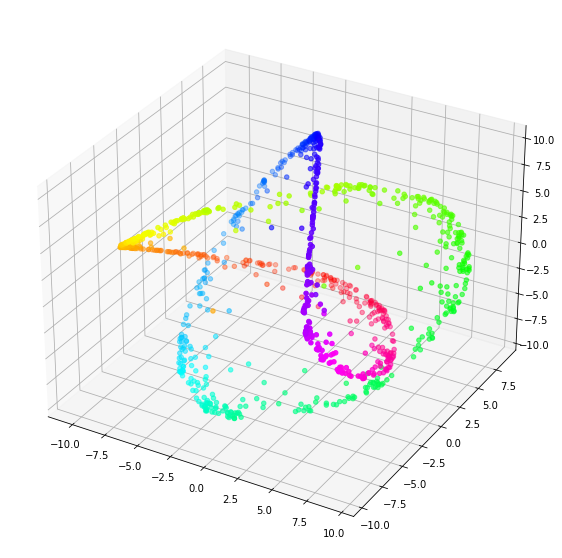

In [59]:
# plot x_cart as 3D scatter plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# plot x_cart as 3D scatter plot, use PS.node_polar_positions[:,1] as color, using a rainbbow colormap
ax.scatter(x_cart[:,3], x_cart[:,4], x_cart[:,2], c=PS.node_polar_positions[:,1].detach().numpy(), cmap='hsv')

In [2]:
u = th.Tensor([0.2, 0.4])
v = th.Tensor([0.5, 0.4])

x = th.Tensor([1.0, 0.2])
y = th.Tensor([1.0, 0.3])

In [234]:
LPGNN.distances.poincare_dist?

Signature: LPGNN.distances.poincare_dist(u: torch.Tensor, v: torch.Tensor, max_r=1)
Docstring: Compute the Poincare distance between two vectors. 
File:      ~/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/distances.py
Type:      function


In [3]:
R_t = 10
print(LPGNN.distances.poincare_dist(u, v, max_r=1))
print(LPGNN.distances.poincare_dist(R_t*u, R_t*v, max_r=R_t))
print(LPGNN.distances.poincare_dist(x, y, max_r=1))
print(LPGNN.distances.poincare_dist(R_t*x, R_t*y, max_r=R_t))

tensor(0.8477)
tensor(0.8477)
tensor(2.5676)
tensor(2.5676)


In [7]:
u_p = LPGNN.distances.to_spherical(u)
v_p = LPGNN.distances.to_spherical(v)
x_p = LPGNN.distances.to_spherical(x)
y_p = LPGNN.distances.to_spherical(y)

In [8]:
hyperbolic_distances(v_p, u_p)

tensor(0.3081)

In [9]:
hyperbolic_distances(x_p, y_p)

tensor(0.1176)

In [12]:
0.3081/0.1176, 2.5676/0.8477

(2.6198979591836733, 3.0289017341040463)

In [6]:
def hyperbolic_distances(pos_0:th.Tensor, pos_1:th.Tensor):
    angular_distance = th.min(2*th.pi-th.abs(pos_1[1]-pos_0[1]), th.abs(pos_1[1]-pos_0[1]))
    d = th.arccosh(th.cosh(pos_1[0])*th.cosh(pos_0[0]) - th.sinh(pos_1[0])*th.sinh(pos_0[0])*th.cos(angular_distance))
    return d